<a href="https://colab.research.google.com/github/mt508/machine-learning-/blob/main/studentperformance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [89]:
import pandas as pd
from zlib import crc32
import numpy as np
from pandas.plotting import scatter_matrix
import seaborn as scn
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV

In [2]:


data_student = pd.read_csv('/content/sample_data/Student_Performance.csv')


In [3]:
data_student.head()

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,Yes,9,1,91.0
1,4,82,No,4,2,65.0
2,8,51,Yes,7,2,45.0
3,5,52,Yes,5,2,36.0
4,7,75,No,8,5,66.0


In [4]:
data_student.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Hours Studied                     10000 non-null  int64  
 1   Previous Scores                   10000 non-null  int64  
 2   Extracurricular Activities        10000 non-null  object 
 3   Sleep Hours                       10000 non-null  int64  
 4   Sample Question Papers Practiced  10000 non-null  int64  
 5   Performance Index                 10000 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 468.9+ KB


observations are


1.   no missing value
2.   string object is 1 extracurricular Activities



array([[<Axes: title={'center': 'Hours Studied'}>,
        <Axes: title={'center': 'Previous Scores'}>],
       [<Axes: title={'center': 'Sleep Hours'}>,
        <Axes: title={'center': 'Sample Question Papers Practiced'}>],
       [<Axes: title={'center': 'Performance Index'}>, <Axes: >]],
      dtype=object)

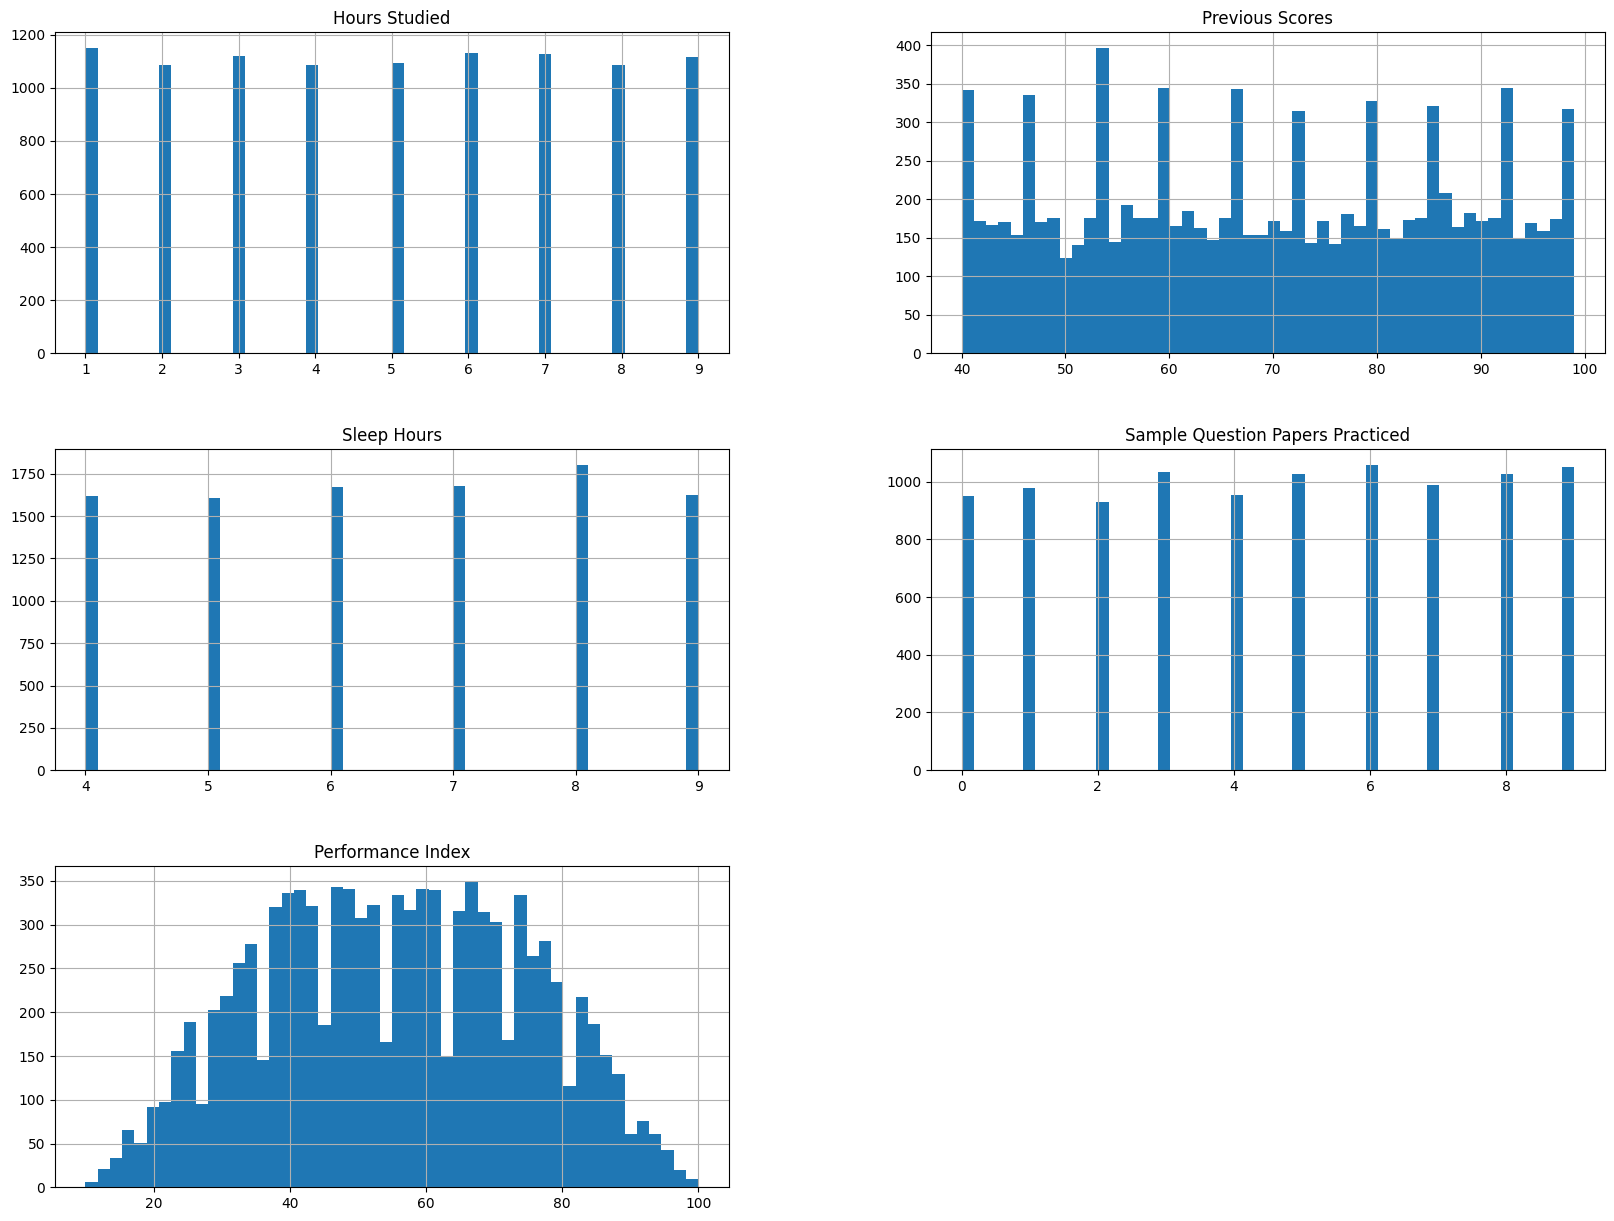

In [5]:
data_student.hist(bins=50, figsize=(20,15))

In [6]:
def is_id_in_test_set(identifier,testratio):
  return crc32(np.int64(identifier))<=testratio*2**32

In [7]:
def split_data(data, id_column,testratio):
  id=data[id_column]
  is_test_set=id.apply(lambda id_:is_id_in_test_set(id_,0.2))
  train_set=data.loc[~is_test_set]
  test_set=data.loc[is_test_set]
  return train_set,test_set

In [8]:
data_with_id=data_student.copy()
data_with_id["id"]=data_with_id.index

In [9]:
train_set,test_set=split_data(data_with_id,"id",0.2)

In [10]:
data_with_id['perf_cat']=pd.cut(data_with_id['Performance Index'],bins=[0, 50, 75, 90, 100],
    labels=[1, 2, 3, 4] )

<Axes: xlabel='perf_cat'>

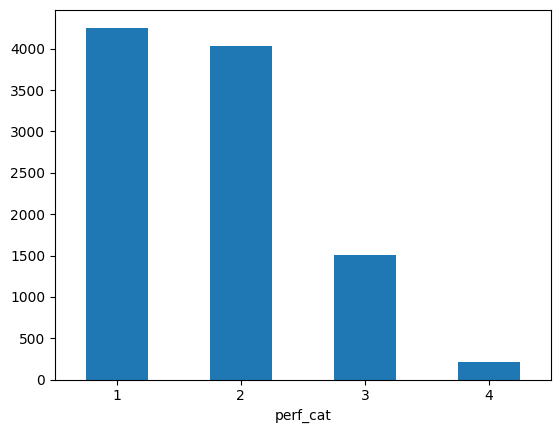

In [11]:
data_with_id['perf_cat'].value_counts().sort_index().plot.bar(rot=0)

In [12]:
from sklearn.model_selection import StratifiedShuffleSplit
start_split=[]
Stratifier= StratifiedShuffleSplit(n_splits=10,test_size=0.2,random_state=42)
for train_index,test_index in Stratifier.split(data_with_id,data_with_id['perf_cat']):
  strat_train_set = data_with_id.iloc[train_index].drop('perf_cat', axis=1)
  strat_test_set = data_with_id.iloc[test_index].drop('perf_cat', axis=1)
  start_split.append((strat_train_set,strat_test_set))


In [13]:
train_set_strat=start_split[0]
test_set_strat=start_split[0]

In [14]:
students=train_set.copy()

In [15]:

corr_matrix = students.select_dtypes(include=['int', 'float']).corr()


In [16]:
corr_matrix['Performance Index'].sort_values(ascending=False)

,Performance Index
Performance Index,1.000000
Previous Scores,0.915552
Hours Studied,0.372066
Sleep Hours,0.052444
Sample Question Papers Practiced,0.046048
id,0.005324


array([[<Axes: xlabel='Previous Scores', ylabel='Previous Scores'>,
        <Axes: xlabel='Performance Index', ylabel='Previous Scores'>,
        <Axes: xlabel='Hours Studied', ylabel='Previous Scores'>],
       [<Axes: xlabel='Previous Scores', ylabel='Performance Index'>,
        <Axes: xlabel='Performance Index', ylabel='Performance Index'>,
        <Axes: xlabel='Hours Studied', ylabel='Performance Index'>],
       [<Axes: xlabel='Previous Scores', ylabel='Hours Studied'>,
        <Axes: xlabel='Performance Index', ylabel='Hours Studied'>,
        <Axes: xlabel='Hours Studied', ylabel='Hours Studied'>]],
      dtype=object)

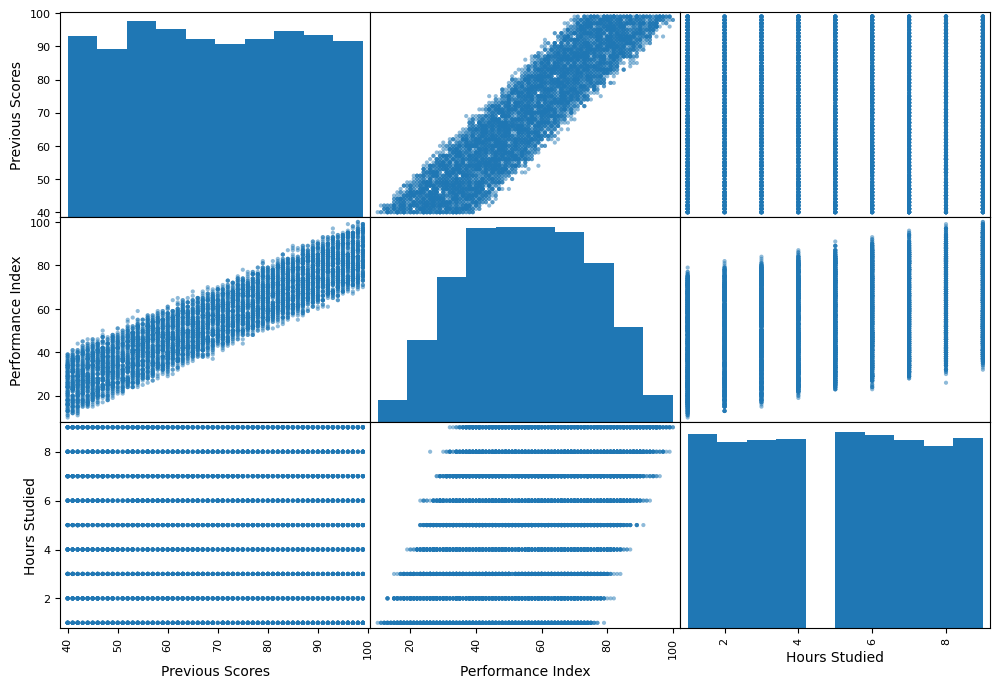

In [17]:
attribute = ['Previous Scores','Performance Index','Hours Studied']
scatter_matrix(students[attribute],figsize=(12,8))

<Axes: xlabel='Previous Scores', ylabel='Performance Index'>

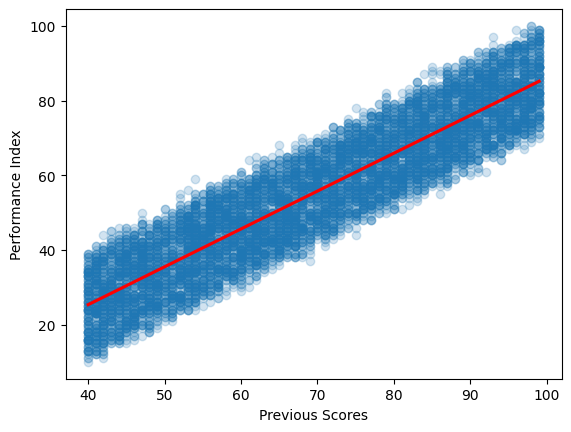

In [18]:
scn.regplot(x='Previous Scores',y='Performance Index',data=students,line_kws={'color':'red'},scatter_kws={'alpha':0.2})

<Axes: xlabel='Hours Studied', ylabel='Performance Index'>

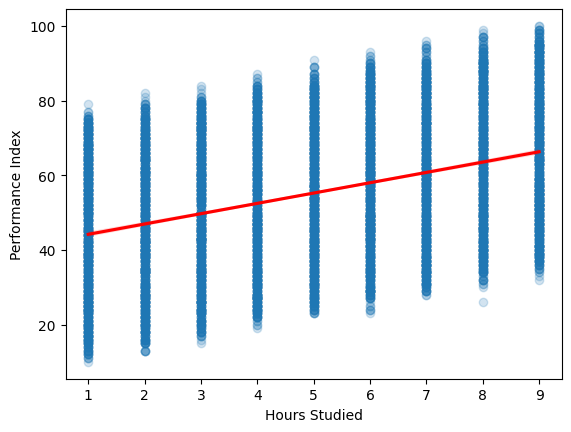

In [19]:
scn.regplot(x='Hours Studied',y='Performance Index',data=students,line_kws={'color':'red'},scatter_kws={'alpha':0.2})

In [20]:
'''def one_hot_encoding(data):
    data_column = data.select_dtypes(include=['object']).columns
    if len(data_column) == 0:
        return data
    else:
        encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        encoded_data = encoder.fit_transform(data[data_column])
        encode_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(data_column), index=data.index)
        data = data.drop(columns=data_column)
        return pd.concat([data, encode_df], axis=1)'''




"def one_hot_encoding(data):\n    data_column = data.select_dtypes(include=['object']).columns\n    if len(data_column) == 0:\n        return data\n    else:\n        encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')\n        encoded_data = encoder.fit_transform(data[data_column])\n        encode_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(data_column), index=data.index)\n        data = data.drop(columns=data_column)\n        return pd.concat([data, encode_df], axis=1)"

In [21]:
'''one_hot_encoding(students)'''

'one_hot_encoding(students)'

In [80]:
def standard_scale():
  return StandardScaler()

In [81]:
def ratio(X):
  X=X.to_numpy()
  return X[:,[0]]/X[:,[1]]
def ratio_name(transformer,feature_name_in):
  return f"{feature_name_in[0]}_per_{feature_name_in[1]}"


In [82]:
def ratio_pipeline():
    return   make_pipeline(
        FunctionTransformer(ratio,feature_names_out=ratio_name),
        StandardScaler()
  )

In [83]:
from scipy.stats import skew

for col in ['Hours Studied', 'Previous Scores', 'Sleep Hours', 'Sample Question Papers Practiced']:
    print(col, "Skewness:", students[col].skew())

Hours Studied Skewness: 0.004142456849320498
Previous Scores Skewness: 0.00615633727171147
Sleep Hours Skewness: -0.0461486714468904
Sample Question Papers Practiced Skewness: -0.04055028746266963


In [84]:
def cat_encoding():
  return  OneHotEncoder(sparse_output=False, handle_unknown='ignore')

In [85]:
num_features = ['Hours Studied', 'Previous Scores', 'Sleep Hours', 'Sample Question Papers Practiced']
cat_features = ['Extracurricular Activities']

preprocessing=ColumnTransformer(
    transformers=[
        ('ratio1',ratio_pipeline(),['Hours Studied','Previous Scores']),
        ('ratio2',ratio_pipeline(),['Sample Question Papers Practiced','Hours Studied']),
        ('ratio3',ratio_pipeline(),['Sample Question Papers Practiced','Previous Scores']),
        ('num',standard_scale(),num_features),
        ('cat',cat_encoding(),cat_features)
    ],remainder= 'passthrough'

 )

In [86]:
lin_reg=make_pipeline(preprocessing,LinearRegression())
label=students['Performance Index']
data=students.drop('Performance Index',axis=1)
lin_reg.fit(data,label)

/usr/local/lib/python3.11/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ratio1',
                                                  Pipeline(steps=[('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x784c3e33d9e0>,
                                                                                       func=<function ratio at 0x784c3e33d080>)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Hours Studied',
                                                   'Previous Scores']),
                                                 ('ratio2',
                                                  Pipeline(st...
                                                                                       func=<function ratio at 0x784c3e33d080>)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Sample Question Papers '
                                                   'Practiced',
                                                   'Previous Scores']),
                                                 ('num', StandardScaler(),
                                                  ['Hours Studied',
                                                   'Previous Scores',
                                                   'Sleep Hours',
                                                   'Sample Question Papers '
                                                   'Practiced']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Extracurricular '
                                                   'Activities'])])),
                ('linearregression', LinearRegression())])

In [30]:
student_pridict=lin_reg.predict(data)
student_pridict[0:10].round(2)

array([91.88, 63.11, 36.54, 67.04, 64.38, 38.25, 62.81, 69.86, 84.25,
       72.45])

AttributeError: 'Pipeline' object has no attribute 'cv_results_'

In [31]:
label[0:10]

,Performance Index
0,91.0
1,65.0
3,36.0
4,66.0
6,63.0
7,42.0
8,61.0
9,69.0
10,84.0
11,73.0


In [33]:
score = cross_val_score(lin_reg,data,label,scoring='neg_root_mean_squared_error',cv=10)
lig_rmse=-score

In [34]:
pd.Series(lig_rmse).describe()

,0
count,10.000000
mean,2.044352
std,0.043486
min,1.989480
25%,2.016554
50%,2.034745
75%,2.070603
max,2.113322


In [43]:
dis_tree=make_pipeline(preprocessing,DecisionTreeRegressor(random_state=42))
dis_tree.fit(data,label)

/usr/local/lib/python3.11/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ratio1',
                                                  Pipeline(steps=[('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x784c4533b420>,
                                                                                       func=<function ratio at 0x784c4533b380>)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Hours Studied',
                                                   'Previous Scores']),
                                                 ('ratio2',
                                                  Pipeline(st...
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Sample Question Papers '
                                                   'Practiced',
                                                   'Previous Scores']),
                                                 ('num', StandardScaler(),
                                                  ['Hours Studied',
                                                   'Previous Scores',
                                                   'Sleep Hours',
                                                   'Sample Question Papers '
                                                   'Practiced']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Extracurricular '
                                                   'Activities'])])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

In [44]:
score_decision_tree=cross_val_score(dis_tree,data,label,scoring='neg_root_mean_squared_error',cv=10)
tree_rsme=-score_decision_tree

In [45]:
pd.Series(tree_rsme).describe()

,0
count,10.000000
mean,3.223937
std,0.148532
min,3.093340
25%,3.143423
50%,3.170661
75%,3.249555
max,3.593223


In [47]:
random_forest=make_pipeline(preprocessing,RandomForestRegressor(random_state=42))
random_forest.fit(data,label)

/usr/local/lib/python3.11/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ratio1',
                                                  Pipeline(steps=[('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x784c4533b420>,
                                                                                       func=<function ratio at 0x784c4533b380>)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Hours Studied',
                                                   'Previous Scores']),
                                                 ('ratio2',
                                                  Pipeline(st...
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Sample Question Papers '
                                                   'Practiced',
                                                   'Previous Scores']),
                                                 ('num', StandardScaler(),
                                                  ['Hours Studied',
                                                   'Previous Scores',
                                                   'Sleep Hours',
                                                   'Sample Question Papers '
                                                   'Practiced']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Extracurricular '
                                                   'Activities'])])),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])

In [48]:
random_forest_score=cross_val_score(random_forest,data,label,scoring='neg_root_mean_squared_error',cv=10)
random_forest_rsme=-random_forest_score

In [49]:
pd.Series(random_forest_rsme).describe()

,0
count,10.000000
mean,2.336918
std,0.063988
min,2.259665
25%,2.290455
50%,2.320088
75%,2.388520
max,2.441672


In [52]:
rf=RandomForestRegressor(random_state=42)
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [60]:
param_grid = {
    'randomforestregressor__n_estimators': [100, 200],
    'randomforestregressor__max_depth': [None, 10, 20],
    'randomforestregressor__min_samples_split': [2, 5],
    'randomforestregressor__min_samples_leaf': [1, 2],
    'randomforestregressor__max_features': ['sqrt', 'log2']
}


In [88]:

param_grid_random = {
    'randomforestregressor__n_estimators': randint(100, 201),             # inclusive range
    'randomforestregressor__max_depth': randint(3, 21),                   # avoid 0 depth
    'randomforestregressor__min_samples_split': randint(2, 11),          # allow more variation
    'randomforestregressor__min_samples_leaf': [1, 2, 4],                # a few more options
    'randomforestregressor__max_features': ['sqrt', 'log2']
}


In [61]:
grid_search = GridSearchCV(
    estimator=random_forest,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error'
)

grid_search.fit(data, label)


/usr/local/lib/python3.11/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ratio1',
                                                                         Pipeline(steps=[('functiontransformer',
                                                                                          FunctionTransformer(feature_names_out=<function ratio_name at 0x784c4533b420>,
                                                                                                              func=<function ratio at 0x784c4533b380>)),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['Hours '
                                                                          'Studied',
                                                                          'Previous '...
                                       ('randomforestregressor',
                                        RandomForestRegressor(random_state=42))]),
             param_grid={'randomforestregressor__max_depth': [None, 10, 20],
                         'randomforestregressor__max_features': ['sqrt',
                                                                 'log2'],
                         'randomforestregressor__min_samples_leaf': [1, 2],
                         'randomforestregressor__min_samples_split': [2, 5],
                         'randomforestregressor__n_estimators': [100, 200]},
             scoring='neg_root_mean_squared_error')

In [63]:
model1=grid_search.best_estimator_

In [67]:
feature_useful = model1.named_steps['randomforestregressor'].feature_importances_

In [68]:
print(feature_useful)

[0.10968743 0.02390527 0.08145052 0.11673111 0.63837746 0.00337491
 0.02077364 0.00064168 0.00065625 0.00440173]


In [75]:

preprocessor = model1.named_steps['columntransformer']


ratio1 = ['Hours Studied_per_Previous Scores']
ratio2 = ['Sample Question Papers Practiced_per_Hours Studied']
ratio3 = ['Sample Question Papers Practiced_per_Previous Scores']
num_features_transformed = preprocessor.named_transformers_['num'].get_feature_names_out()

cat_transformer = preprocessor.named_transformers_['cat']
cat_features = cat_transformer.get_feature_names_out(['Extracurricular Activities'])

all_feature_names = ratio1 + ratio2 + ratio3 + list(num_features_transformed) + list(cat_features)

importances = model1.named_steps['randomforestregressor'].feature_importances_

# 6. Sort and display feature importances
for importance, name in sorted(zip(importances, all_feature_names), reverse=True):
    print(f"{name}: {importance:.4f}")


Previous Scores: 0.6384
Hours Studied: 0.1167
Hours Studied_per_Previous Scores: 0.1097
Sample Question Papers Practiced_per_Previous Scores: 0.0815
Sample Question Papers Practiced_per_Hours Studied: 0.0239
Sample Question Papers Practiced: 0.0208
Sleep Hours: 0.0034
Extracurricular Activities_Yes: 0.0007
Extracurricular Activities_No: 0.0006


In [90]:
random_cv=RandomizedSearchCV(
    estimator=random_forest,
    param_distributions=param_grid_random,
    cv=5,
    scoring='neg_root_mean_squared_error',

)


In [91]:
random_cv.fit(data,label)

/usr/local/lib/python3.11/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ratio1',
                                                                               Pipeline(steps=[('functiontransformer',
                                                                                                FunctionTransformer(feature_names_out=<function ratio_name at 0x784c4533b420>,
                                                                                                                    func=<function ratio at 0x784c4533b380>)),
                                                                                               ('standardscaler',
                                                                                                StandardScaler())]),
                                                                               ['Hours '
                                                                                'Studied',
                                                                                'Pre...
                                        'randomforestregressor__max_features': ['sqrt',
                                                                                'log2'],
                                        'randomforestregressor__min_samples_leaf': [1,
                                                                                    2,
                                                                                    4],
                                        'randomforestregressor__min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x784c3d2a3ed0>,
                                        'randomforestregressor__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x784c3dbf1c10>},
                   scoring='neg_root_mean_squared_error')

In [92]:
model2=random_cv.best_estimator_

In [93]:
important_feature=model2['randomforestregressor'].feature_importances_

In [94]:
print(important_feature)

[1.06228953e-01 2.46604351e-02 7.84193208e-02 1.14371492e-01
 6.47622146e-01 3.40843513e-03 1.96199903e-02 6.06121341e-04
 5.88871851e-04 4.47423364e-03]


In [98]:
cv_result=pd.DataFrame(grid_search.cv_results_)
cv_result.sort_values(by='mean_test_score',ascending=False,inplace=True)
cv_result.head()


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_randomforestregressor__max_depth,param_randomforestregressor__max_features,param_randomforestregressor__min_samples_leaf,param_randomforestregressor__min_samples_split,param_randomforestregressor__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
5,2.438062,0.311320,0.095841,0.003821,None,sqrt,2,2,200,"{'randomforestregressor__max_depth': None, 'ra...",-2.360288,-2.283589,-2.217052,-2.296941,-2.349286,-2.301431,0.051405,1
13,2.399282,0.187719,0.110129,0.023193,None,log2,2,2,200,"{'randomforestregressor__max_depth': None, 'ra...",-2.360288,-2.283589,-2.217052,-2.296941,-2.349286,-2.301431,0.051405,1
37,2.397747,0.241701,0.101975,0.013401,20,sqrt,2,2,200,"{'randomforestregressor__max_depth': 20, 'rand...",-2.362140,-2.287380,-2.214574,-2.296587,-2.355072,-2.303151,0.053504,3
45,2.416584,0.201789,0.106141,0.015873,20,log2,2,2,200,"{'randomforestregressor__max_depth': 20, 'rand...",-2.362140,-2.287380,-2.214574,-2.296587,-2.355072,-2.303151,0.053504,3
43,2.432471,0.342155,0.095616,0.004593,20,log2,1,5,200,"{'randomforestregressor__max_depth': 20, 'rand...",-2.345203,-2.285351,-2.201577,-2.307800,-2.385035,-2.304993,0.061826,5


In [99]:
cv_result_random=pd.DataFrame(random_cv.cv_results_)
cv_result_random.sort_values(by='mean_test_score',ascending=False,inplace=True)
cv_result_random.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_randomforestregressor__max_depth,param_randomforestregressor__max_features,param_randomforestregressor__min_samples_leaf,param_randomforestregressor__min_samples_split,param_randomforestregressor__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
6,1.959486,0.095553,0.084388,0.008153,18,log2,1,5,169,"{'randomforestregressor__max_depth': 18, 'rand...",-2.367419,-2.294341,-2.210187,-2.308471,-2.367444,-2.309572,0.057976,1
5,1.578804,0.177395,0.069125,0.007783,14,log2,2,5,136,"{'randomforestregressor__max_depth': 14, 'rand...",-2.361185,-2.286760,-2.221434,-2.302264,-2.392175,-2.312764,0.059629,2
1,1.489525,0.262258,0.065287,0.009143,16,log2,2,7,133,"{'randomforestregressor__max_depth': 16, 'rand...",-2.347041,-2.290796,-2.220158,-2.304976,-2.402237,-2.313041,0.060496,3
8,2.111728,0.249821,0.086507,0.009053,19,log2,2,4,174,"{'randomforestregressor__max_depth': 19, 'rand...",-2.382612,-2.282262,-2.226851,-2.301677,-2.371865,-2.313053,0.057975,4
7,1.085568,0.177659,0.049116,0.005737,16,log2,4,2,103,"{'randomforestregressor__max_depth': 16, 'rand...",-2.356879,-2.308035,-2.234959,-2.324712,-2.409079,-2.326733,0.057386,5
